In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

#import keras
#import tensorflow as tf
from keras import regularizers, initializers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D,Conv2D, MaxPooling1D,MaxPooling2D,MaxPooling3D, AveragePooling1D
from scipy.signal import detrend
import tensorflow.random as tf_r
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import clone_model

# random seed for reproducibility
np.random.seed(12345)
tf_r.set_seed(12345) 
plt.style.use('seaborn')


# Data Generation

We will generate `N` samples composed by 2 time series of lenght `L`, populate each of these time series with a Brownian walk, and then add a `bump` pattern consisting of half the period of a sine wave, with amplitude and sign depending on the sample label.

In [2]:
# we want to add this pattern at various points of the gaussian time series and see if the CNN finds it

def pattern(i,z,a):
    # Z is the lenght of the "bump" due to half sin oscillation
    # a is the amplitude
    return int(a*np.sin((np.pi*i)/z))

In [3]:
N = 1000 # number of samples, prima era 100000
L = 200 # time-points in each samples
D = 2 # number of time series

DX = 50 # std of gaussian noise
bias = 5 # bias of gaussian noise

# pattern properties
signal_to_noise = 100 #prima era 10
Z = 12
A = signal_to_noise*DX # default is 10*DX

n_class=3


x = np.zeros((N,L,D)) # empty array with N rows of (L,D) cells (samples)
y_l = np.random.randint(-1,2,N) # array of N random numbers between 0 and 2 representing the label
                                # 0 : no pattern
                                # -1 : first negative pattern and then positive one
                                # 1 : first positive pattern and then negative one

for i in range(x.shape[0]): # running through every sample
    
    # generate noisy time series
    for j in range(x.shape[1]): # running through every time point
        if j == 0:
            x[i][j] = np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # starting gaussian noise

        else:
            x[i][j] = x[i][j-1] + np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # adding gaussian noise

    # generate pattern
    # we will generate them with a little temporal offset of 3 time points
    offset = 10
    j0 = np.random.randint(0,x.shape[1]-(Z+offset)) # do not pick the random pattern starting point closer to the edge than a whole pattern
    sign = np.sign(y_l[i])

    for j in range(0,Z):
        x[i][j0+j][0] += sign*pattern(j,Z,A)
        x[i][j0+j+offset][1] += -sign*pattern(j/2,Z,A) # second pattern a bit shifted and with a different shape,opposite sign

In [4]:
# now to reorganize the label: instead of having an array of N numbers being either 0 or 1 or 2 corresponding to the three classes
# we will have a (N,3) array with each of the N entry being a zero vector with a 1 where the corresponding class is.
y = np.zeros((N,3))

for i in range(N):
    y[i][y_l[i] + 1] = 1

In [23]:
#counting how many elements for each class
print("N# of elements in each class")
print(np.count_nonzero(y,axis=0))
# mask for elements of each class
first_class=np.argwhere(y[:,0]==1).reshape(-1)
second_class=np.argwhere(y[:,1]==1).reshape(-1)
third_class=np.argwhere(y[:,2]==1).reshape(-1)

N# of elements in each class
[325 352 323]


[105, 84, 76]


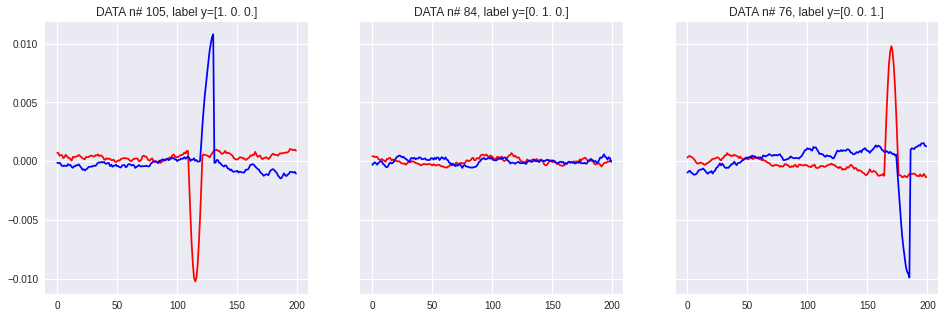

In [30]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5), sharey = True)
colors=['red','blue']
i=np.random.randint(30)
i_plts = [first_class[i],second_class[i],third_class[i]]
print(i_plts)
for ax, i_plt in zip(axs,i_plts):
    for d in range(D):
         ax.plot(x[i_plt,:,d],color=colors[d])
    ax.set_title("DATA n# {}, label y={}".format(i_plt,y[i_plt]))

plt.show()        

In [31]:
# save data
! mkdir -p DATA2_03
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
fname='DATA2_03/x_'+str0
# we need to save them as .npy files as tabular data generated by savetxt cannot store 3D or higher dimensional arrays
np.save(fname,x)
fname='DATA/y_'+str0
np.save(fname,y)

# Data preparation

Now for data preparation: we will not reload the files as they have been generated in this very notebook.

First thing we will try to *detrend* the data: that is, assume a linear background trend, we will interpolate this drift and subtract it from the original time series. To do that, we will implement the convenient `scipy.detrend` 's routine. Then we will rescale data by its variance.

In [32]:
# DETRENDING AND RESCALING

for i in range(x.shape[0]):
    for d in range(x.shape[2]):
        x[i,:,d] = detrend(x[i,:,d])
        
x = x/np.var(x)

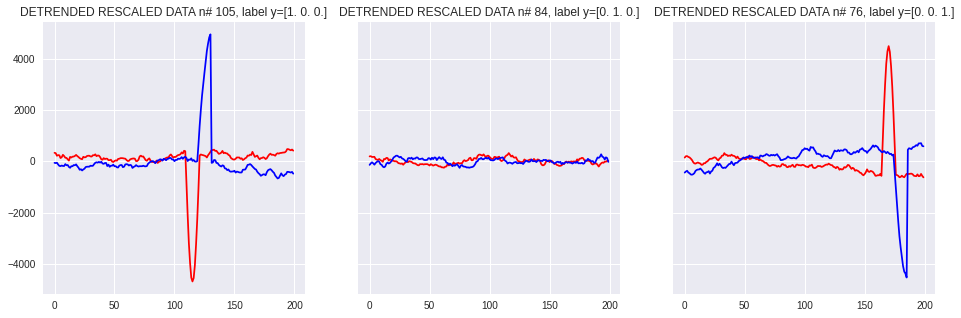

In [33]:
#plotting 1 rescaled-detrended sample for each class

colors = ['red', 'blue']

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5), sharey = True)
for ax, i_plt in zip(axs,i_plts):
    for d in range(D):
         ax.plot(x[i_plt,:,d],color=colors[d])
    ax.set_title("DETRENDED RESCALED DATA n# {}, label y={}".format(i_plt,y[i_plt]))

plt.show()        

## Train-Test Split

In [34]:
perc_training = 0.8
n_train = int(x.shape[0]*0.8)

x_train,y_train = x[:n_train],y[:n_train]
x_val,y_val = x[n_train:],y[n_train:]


# Keras wants an additional dimension ???
# because Conv2D input is (samples,height,width,channels)


x_train = x_train.reshape(x_train.shape[0], L,D,1)
x_val =  x_val.reshape(x_val.shape[0], L,D,1)

print(x.shape)
print(x_train.shape)

(1000, 200, 2)
(800, 200, 2, 1)


# Build model


In [36]:
#ridge regularization
reg = regularizers.l2(0.0002) # l2 is ridge, l1 would be lasso

# initializing weights
ini = initializers.RandomNormal(mean=1.0, stddev=0.05, seed=12345)

M = 15 # lenght of kernel: its shape will be (M,2)


In [37]:
# defining the model

model = Sequential()

model.add(Conv2D(filters=2, kernel_size = (M,2), kernel_initializer=ini, kernel_regularizer=reg,\
                 input_shape=x_train[0].shape, use_bias=False))

# lets try to build a pooling such that we detect the maximum correlation at some point in time
# this pools 2 neighbouring points along time axis
# so that output is half the width. hopefully this will catch the offset

model.add(MaxPooling2D(pool_size=(2,1)))

model.add(Conv2D(filters=2, kernel_size = (int(M/2),1)))

model.add(Flatten())
model.add(Dense(12,activation='sigmoid')) # 12 neurons layer
model.add(Dense(n_class,activation='softmax'))

print('----- MODEL SUMMARY ------')
print(model.summary())


opt = Adam()

# compile the model
model.compile(loss=categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

----- MODEL SUMMARY ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 1, 2)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 2)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 1, 2)          30        
                                                                 
 flatten (Flatten)           (None, 174)               0         
                                                                 
 dense (Dense)               (None, 12)                2100      
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                             

In [13]:
model.layers

In [14]:
w = model.layers[0].get_weights()[0]
print(w.shape) #2 filters, for 1 channel, of a 15x2 kernel
# print(b.shape) # 3 bias for each filter

(15, 2, 1, 2)


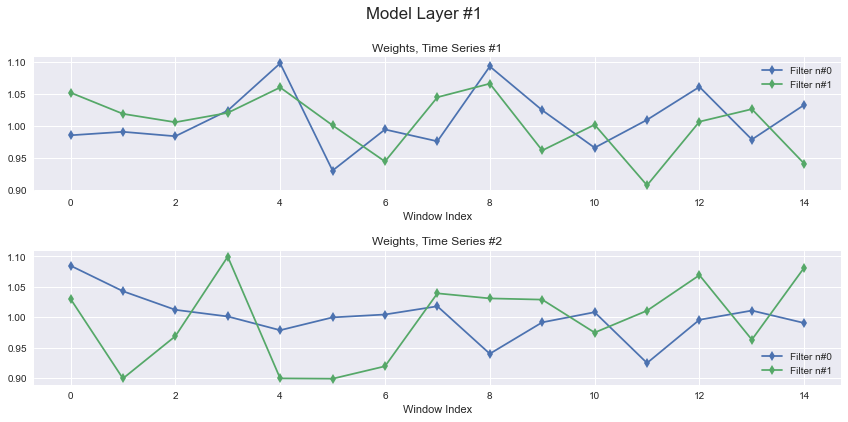

In [15]:
#plotting weights of the first convolutional layer befor training

fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,1,0,i],marker='d',label=f'Filter n#{i}') #cambiato: prima era w[:,0,0,i]
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()

# Training


In [16]:
batch_size = 100 #prima era 1000
epochs = 250

print('------- Model  ------- \n FITTING....')
fit = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=0,shuffle=True)

------- Model  ------- 
 FITTING....


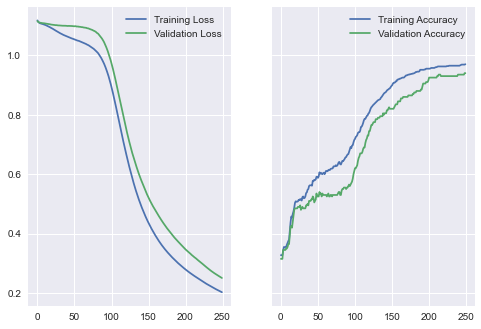

In [30]:
#plotting loss and accuracy curves

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True)
ax[0].plot(fit.history['loss'],label='Training Loss')
ax[0].plot(fit.history['val_loss'],label='Validation Loss')
ax[1].plot(fit.history['accuracy'],label='Training Accuracy')
ax[1].plot(fit.history['val_accuracy'],label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

(15, 2, 1, 2)


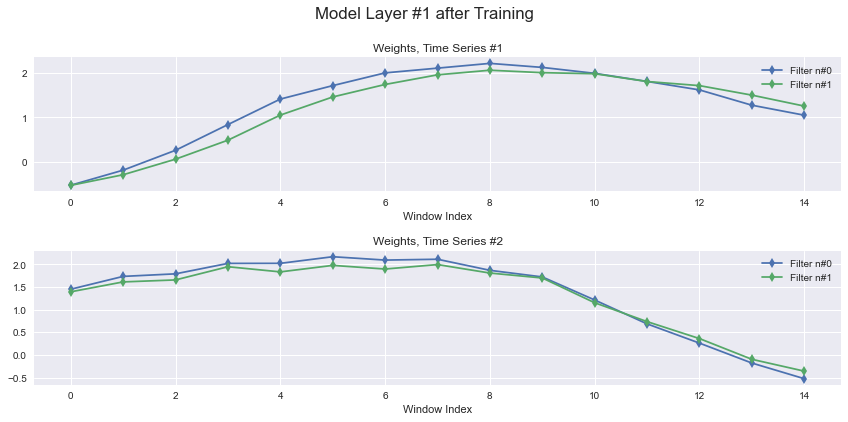

In [18]:
w=model.layers[0].get_weights()[0]
print(w.shape) # 2 filters, for 1 channel, of a 20x1 kernel

fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1 after Training')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,1,0,i],marker='d',label=f'Filter n#{i}')
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()

## Regularization grid search


The initial weights somehow resemble half-sine bump pattern we introduced; the opposite sign due to differently labeled "bumps" is probably accounted for in the hidden layer. Let's test this model with different regularization parameters:

In [19]:
lambdas = [10**(-i) for i in range(4)]
histories = {}
best_la = lambdas[0]

for la in lambdas:

    print("---- FITTING WITH LAMBDA = {} ----".format(la))


    model_cp = clone_model(model)
    reg = regularizers.L2(la)
    model_cp.layers[0].kernel_regularizer = reg
    model_cp.compile(loss = categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

    fit_cp=model_cp.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),\
                        verbose=0,shuffle=True) 
    histories[str(la)] = fit_cp.history
    if histories[str(la)]['loss'][-1] < histories[str(best_la)]['loss'][-1]: 
        best_la = la

print(best_la)

---- FITTING WITH LAMBDA = 1 ----
---- FITTING WITH LAMBDA = 0.1 ----
---- FITTING WITH LAMBDA = 0.01 ----
---- FITTING WITH LAMBDA = 0.001 ----
0.1


0.11047638952732086
0.0742502436041832
0.08821365237236023
0.0922478511929512


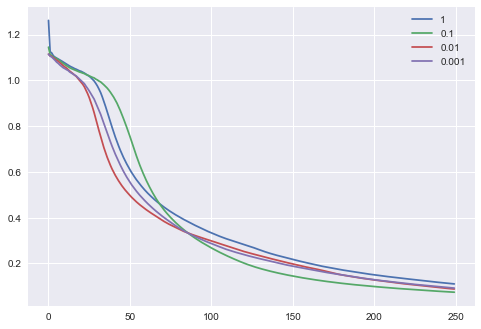

In [20]:
for key in histories:
    plt.plot(histories[key]['loss'],label=key)
    print(histories[key]['loss'][-1])

plt.legend()

# Increasing signal strenght in data generation


In [21]:
'''
# pattern properties
signal_to_noise = 100
Z = 12
A = signal_to_noise*DX # default is 10*DX
'''

'\n# pattern properties\nsignal_to_noise = 100\nZ = 12\nA = signal_to_noise*DX # default is 10*DX\n'

In [22]:
'''
x = np.zeros((N,L,D)) # empty array with N rows of (L,D) cells (samples)
y_l = np.random.randint(0,3,N) # array of N random numbers between 0 and 2 representing the label
                             # 0 : large pattern positive
                             # 1 : pattern present positive
                             # 2 : pattern present negative

for i in range(x.shape[0]): # running through every sample
    
    # generate noisy time series
    for j in range(x.shape[1]): # running through every time point
        if j == 0:
            x[i][j] = np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # starting gaussian noise

        else:
            x[i][j] = x[i][j-1] + np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # adding gaussian noise

    # generate pattern
    # we will generate them with a little temporal offset of 3 time points
    offset = 3
    j0 = np.random.randint(0,x.shape[1]-(Z+offset)) # do not pick the random pattern starting point closer to the edge than a whole pattern
    sign = 3-2*y_l[i]

    for j in range(0,Z):
        x[i][j0+j][0] += sign*pattern(j,Z,A)
        x[i][j0+j+offset][1] += -sign*pattern(j/2,Z,A) # second pattern a bit shifted and with a different shape,opposite sign
'''

'\nx = np.zeros((N,L,D)) # empty array with N rows of (L,D) cells (samples)\ny_l = np.random.randint(0,3,N) # array of N random numbers between 0 and 2 representing the label\n                             # 0 : large pattern positive\n                             # 1 : pattern present positive\n                             # 2 : pattern present negative\n\nfor i in range(x.shape[0]): # running through every sample\n    \n    # generate noisy time series\n    for j in range(x.shape[1]): # running through every time point\n        if j == 0:\n            x[i][j] = np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # starting gaussian noise\n\n        else:\n            x[i][j] = x[i][j-1] + np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # adding gaussian noise\n\n    # generate pattern\n    # we will generate them with a little temporal offset of 3 time points\n    offset = 3\n    j0 = np.random.randint(0,x.shape[1]-(Z+offset)) # do not pick the random pattern startin

In [23]:
'''
# now to reorganize the label: instead of having an array of N numbers being either 0 or 1 or 2 corresponding to the three classes
# we will have a (N,3) array with each of the N entry being a zero vector with a 1 where the corresponding class is.
y = np.zeros((N,3))

for i in range(N):
    y[i][y_l[i]] = 1
'''

'\n# now to reorganize the label: instead of having an array of N numbers being either 0 or 1 or 2 corresponding to the three classes\n# we will have a (N,3) array with each of the N entry being a zero vector with a 1 where the corresponding class is.\ny = np.zeros((N,3))\n\nfor i in range(N):\n    y[i][y_l[i]] = 1\n'

In [24]:
'''
# data preprocessing

from scipy.signal import detrend

# DETREND
for i in range(x.shape[0]):
    for d in range(x.shape[2]):
        x[i,:,d] = detrend(x[i,:,d])

# RESCALING
x = x/np.var(x)
'''

'\n# data preprocessing\n\nfrom scipy.signal import detrend\n\n# DETREND\nfor i in range(x.shape[0]):\n    for d in range(x.shape[2]):\n        x[i,:,d] = detrend(x[i,:,d])\n\n# RESCALING\nx = x/np.var(x)\n'

In [25]:
'''
#model

model_stronger = tf.keras.models.clone_model(model)
model_stronger.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

fit_stronger=model_stronger.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=1,shuffle=True)
'''

"\n#model\n\nmodel_stronger = tf.keras.models.clone_model(model)\nmodel_stronger.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])\n\nfit_stronger=model_stronger.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=1,shuffle=True)\n"

In [26]:
'''
plt.plot(fit_stronger.history['loss'],label='Training loss')
plt.plot(fit_stronger.history['val_loss'],label='Validation loss')
plt.title("Training over dataset less noisy")
plt.legend()
'''

'\nplt.plot(fit_stronger.history[\'loss\'],label=\'Training loss\')\nplt.plot(fit_stronger.history[\'val_loss\'],label=\'Validation loss\')\nplt.title("Training over dataset less noisy")\nplt.legend()\n'

In [27]:
'''
plt.plot(fit_stronger.history['accuracy'],label='Training accuracy')
plt.plot(fit_stronger.history['val_accuracy'],label='Validation accuracy')
plt.title("Training over dataset less noisy")
plt.legend()
'''

'\nplt.plot(fit_stronger.history[\'accuracy\'],label=\'Training accuracy\')\nplt.plot(fit_stronger.history[\'val_accuracy\'],label=\'Validation accuracy\')\nplt.title("Training over dataset less noisy")\nplt.legend()\n'

In [28]:
'''
w=model_stronger.layers[0].get_weights()[0]
print(w.shape) # 3 filters, for 1 channel, of a 20x1 kernel

fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1 after Training over less noisy dataset')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()
'''

"\nw=model_stronger.layers[0].get_weights()[0]\nprint(w.shape) # 3 filters, for 1 channel, of a 20x1 kernel\n\nfig,axs = plt.subplots(2,1,figsize=[12,6])\nfig.suptitle('Model Layer #1 after Training over less noisy dataset')\nfor i in range(w.shape[-1]): # for every filter\n    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')\naxs[0].legend()\naxs[0].set_title('Weights, Time Series #1')\naxs[0].set_xlabel('Window Index')\n\nfor i in range(w.shape[-1]): # for every filter\n    axs[1].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')\naxs[1].legend()\naxs[1].set_title('Weights, Time Series #2')\naxs[1].set_xlabel('Window Index')\n\n\nfig.tight_layout()\n"